# DMQC Report: WMO 4901784

## Current status and metadata: 

- DOVA float, inactive as of November 2021
- Completed 234 cycles in mid-North Pacific
- In 'A' mode
- Adjusted data is erroneously high, large gain of 1.61 applied to raw DOXY
- Calculated mean gain of 1.0496

In [1]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib.dates import datestr2num
import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np
import pandas as pd
import bgcArgoDMQC as bgc

wmo = 4901784
flt = bgc.sprof(wmo)
flt.clean()
gains = flt.calc_gains(ref='WOA')
print(np.nanmean(gains))

# flt.plot('map') # not built yet

Extracting WOA data for Jan
Extracting WOA data for Feb
Extracting WOA data for Mar
Extracting WOA data for Apr
Extracting WOA data for May
Extracting WOA data for Jun
Extracting WOA data for Jul
Extracting WOA data for Aug
Extracting WOA data for Sep
Extracting WOA data for Oct
Extracting WOA data for Nov
Extracting WOA data for Dec

Calculating gains using WOA surface data and float O2 percent saturation...
1.0499536482812732


## DOXY Audit Status

- Many points flagged as problematic, likely due to the erroneously high adjusted value. Those points look fine in raw data.
- Mean raw DOXY gain of 1.0472

In [2]:
audit_file = list(Path('../../audit/').glob('DOXY_WOA*'))[-1]
df = pd.read_csv(audit_file, sep='\t', header=25)
df = df.loc[df.WMO == wmo]
df['date'] = [datestr2num(t) for t in df['profile date']]
print(f"{df['WOA G_raw'].mean():.4f}")

1.0472


## Visual QC

Check the profiles and any anomolous looking saturation values.

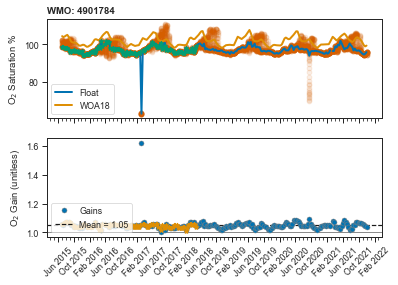

In [3]:
g = flt.plot('gain', ref='WOA')
g.axes[0].set_title(f'WMO: {wmo}', loc='left', fontweight='bold')
g.axes[0].plot(df['date'], df['flt O2 %sat'], '*')
g.axes[1].plot(df['date'], df['WOA G_raw'], '*', zorder=3)
g.axes[0].plot(flt.df.SDN.loc[flt.df.PRES < 50], flt.df.O2Sat.loc[flt.df.PRES < 50], 'o', zorder=0, alpha=0.1)
g.fig.savefig('../../figures/4901784_before.png', dpi=300, bbox_inches='tight')

Figure 1: Top panel: Float oxygen percent saturation (blue line) compared to WOA percent saturation (orange line), with DOXY audit flagged cycle percent saturation (green stars) and raw float percent saturation (orange circles, background). Bottom panel: calculated gains (blue dots) and flagged gains from DOXY audit (orange stars).

Notes: seemingly problematic profiles in early 2017 and mid-2020. DOXY audit flags a lot of points that are probably good, but that is due to the erroneously high adjusted DOXY (bad gain of 1.61 applied). Possibly coincidental, but that outlier gain is about 1.61 - perhaps a point was flagged in a previous DOXY audit, and accidentally applied to the float rather than being flagged as 4. SCIENTIFIC_CALIB_COMMENT states "G obtained from DOXY audit on 2020-02-24".

(200.0, 0.0)

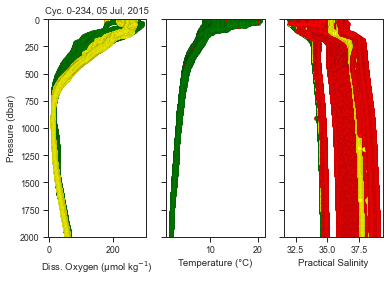

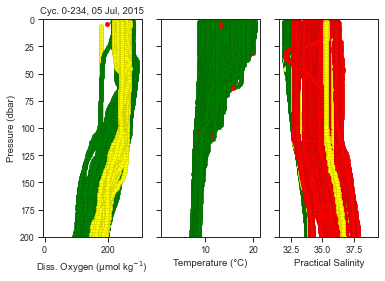

In [4]:
flt.reset()
g = flt.plot('qcprofiles', varlist=['DOXY', 'TEMP', 'PSAL'])
g = flt.plot('qcprofiles', varlist=['DOXY', 'TEMP', 'PSAL'])
g.axes[0].set_ylim((200,0))

Figures 2,3: Profiles coloured by QC flag (1-2, green, 3, yellow, 4, red) on difference depth scales.

Notes: Can pretty clearly see the two deliquent profiles shown in figure 1. Will isolate those profiles and consider whether to make the whole profile as bad or just the top sections of them. 

In [5]:
problem_cycles = flt.df.CYCLE.loc[(flt.df.DOXY < 200) & (flt.df.PRES < 50)].unique()
print(problem_cycles)

[ 61. 190.]


(0.0, 120.0)

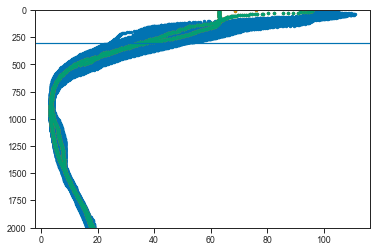

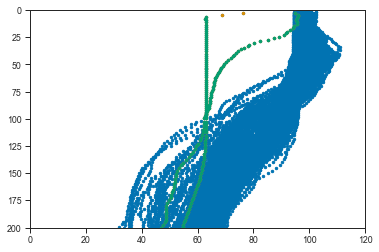

In [6]:
fig, ax = plt.subplots()
ix = flt.df.CYCLE.isin(problem_cycles)
ax.plot(flt.df.O2Sat, flt.df.PRES, '.')
ax.plot(flt.df.O2Sat.loc[ix], flt.df.PRES.loc[ix], '.')
flt.clean()
ax.plot(flt.df.O2Sat.loc[ix], flt.df.PRES.loc[ix], '.')
ax.set_ylim((2000,0))
ax.axhline(300)

flt.reset()
fig, ax = plt.subplots()
ix = flt.df.CYCLE.isin(problem_cycles)
ax.plot(flt.df.O2Sat, flt.df.PRES, '.')
ax.plot(flt.df.O2Sat.loc[ix], flt.df.PRES.loc[ix], '.')
flt.clean()
ax.plot(flt.df.O2Sat.loc[ix], flt.df.PRES.loc[ix], '.')
ax.set_ylim((200,0))
ax.set_xlim((0, 120))


Figures 4, 5: Better highlights of the problem profiles. There are some DOXY_QC=4 already (orange points).

Notes: I think either more or all of these two profiles should be flagged bad. Below 300 dbar looks ok to me so for now I will keep those points. 

## Flag bad data, recalculate gain

- new mean gain of 1.0466

In [7]:
bad_oxygen = flt.df.CYCLE.isin(problem_cycles) & (flt.df.PRES < 300)
flt.update_field('DOXY_QC', 4, where=bad_oxygen)
flt.update_field('DOXY_ADJUSTED_QC', 4, where=bad_oxygen)
flt.clean()
new_gains = flt.calc_gains(ref='WOA')
print(np.nanmean(new_gains))


Calculating gains using WOA surface data and float O2 percent saturation...
1.0472442705293319


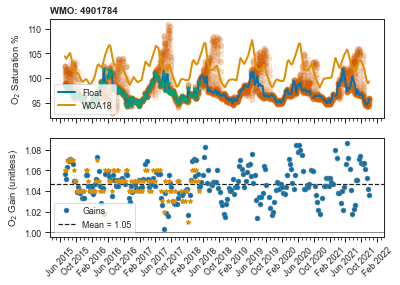

In [8]:
g = flt.plot('gain', ref='WOA')
g.axes[0].set_title(f'WMO: {wmo}', loc='left', fontweight='bold')
g.axes[0].plot(df['date'], df['flt O2 %sat'], '*')
g.axes[1].plot(df['date'], df['WOA G_raw'], '*', zorder=3)
g.axes[0].plot(flt.df.SDN.loc[flt.df.PRES < 50], flt.df.O2Sat.loc[flt.df.PRES < 50], 'o', zorder=0, alpha=0.1)
g.fig.savefig('../../figures/4901784_after.png', dpi=300, bbox_inches='tight')


In [9]:
# get the mean gain
flt.update_field('DOXY_QC', 3, where=flt.DOXY_QC == 1)
flt.update_field('DOXY_QC', 3, where=flt.DOXY_QC == 0)
flt.update_field('DOXY_ADJUSTED', flt.gain*flt.DOXY)
flt.update_field('DOXY_ADJUSTED_ERROR', bgc.calc_fixed_doxy_adjusted_error(flt.PSAL, flt.TEMP, flt.PRES))
flt.update_field('DOXY_ADJUSTED_QC', flt.DOXY_QC)
flt.update_field('DOXY_ADJUSTED_QC', 1, where=flt.DOXY_ADJUSTED_QC == 3)
flt.update_field('DOXY_ADJUSTED_QC', 1, where=flt.DOXY_ADJUSTED_QC == 0)
flt.update_field('DOXY_ADJUSTED_QC', 4, where=flt.TEMP_ADJUSTED_QC == 4)
flt.update_field('DOXY_ADJUSTED_QC', 3, where=flt.PSAL_ADJUSTED_QC == 4)
flt.set_fillvalue('DOXY_ADJUSTED', where=flt.DOXY_ADJUSTED_QC == 4)
flt.set_fillvalue('DOXY_ADJUSTED_ERROR', where=flt.DOXY_ADJUSTED_QC == 4)

In [10]:
flt.export_files(data_mode='D')

Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4901784/profiles/BD4901784_000.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4901784/profiles/BD4901784_001.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4901784/profiles/BD4901784_002.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4901784/profiles/BD4901784_003.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4901784/profiles/BD4901784_004.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4901784/profiles/BD4901784_005.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4901784/profiles/BD4901784_006.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4901784/profiles/BD4901784_007.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4901784/profiles/BD4901784_008.nc...done
Working on